# An investigation on the Centroid location in Fiber Sections

In this Jupyter the Centroid of a rectangle fiber section is investigated and by changing the location of the centroid (using '-noCentroid') its effect on the results are watched. Results are checked by handy calculations.

By: Bijan Sayyafzadeh [Email](B.sayyaf@yahoo.com) [Github](https://github.com/BijanSeif) [LinkedIn](linkedin.com/in/bijan-sayyafzadeh-6027aa7a)

## Cantiliver Elastic Model Function

In [33]:
def Model(P, Mz, crdsIz, crdsIy, crdsJz, crdsJy, numSubdivY, numSubdivZ):
    import openseespy.opensees as ops

    ops.wipe()
    ops.model('basic','-ndm',3)
    L=100
    ops.node(1,0,0,0)
    ops.node(2,L,0,0)
    ops.fix(1,1,1,1,1,1,1)

    matTag=1
    E=2.1e6
    epsyP=1
    ops.uniaxialMaterial('ElasticPP', matTag, E, epsyP)

    transfTag=1
    ops.geomTransf('Linear', transfTag,*[0,0,1])

    secTag=1
    GJ=1
    ops.section('Fiber', secTag, '-GJ', GJ,'-noCentroid')


    crdsI=[crdsIy, crdsIz]
    crdsJ=[crdsJy, crdsJz]
    b=abs(crdsIz-crdsJz)
    h=abs(crdsIy-crdsJy)
    I=b*h**3/12
    ops.patch('rect', matTag, numSubdivY, numSubdivZ, *crdsI, *crdsJ)


    integrationTag=1
    N=3
    ops.beamIntegration('Radau', integrationTag, secTag, N)


    eleTag=1
    eleNodes=[1,2]
    ops.element('forceBeamColumn', eleTag, *eleNodes, transfTag, integrationTag)

    tstag=1
    ops.timeSeries('Linear', tstag)
    patternTag=1
    ops.pattern('Plain', patternTag, tstag)
    nodeTag=2

    ops.load(nodeTag, *[P,0,0,0,0,Mz])


    # create the analysis
    ops.wipeAnalysis()                     # clear previously-define analysis parameters
    ops.constraints('Plain')               # how it handles boundary conditions
    ops.numberer('Plain')                  # renumber dof's to minimize band-width (optimization), if you want to
    ops.system('BandGeneral')              # how to store and solve the system of equations in the analysis
    ops.algorithm('Linear')                # use Linear algorithm for linear analysis
    ops.integrator("LoadControl", 0.1)     # create integrator
    ops.analysis("Static")                 # create analysis object

    # perform the analysis
    ops.analyze(10)
    ops.reactions()
    print(f'Support Reaction (Px,Mz,My)=({round(ops.nodeReaction(1,1),2)}', 
                                         f'{round(ops.nodeReaction(1,6),2)}',
                                         f'{round(ops.nodeReaction(1,5),2)})\n')
#     print('\nmaximum End Displacement =\n',ops.nodeDisp(2))

    print('-------------------------------------------------------------------------------------------------------------------')
    #                      eleTag             secNum
    data = ops.eleResponse(eleTag,'section',3,'fiberData')
    # print('\nAll Fiber Data=',data, '\n')

    Ndata = len(data)
    Nfibers = int(Ndata/5)
    #print('Nfibers=',Nfibers, '\n')

    y = data[0:Ndata:5]
    z = data[1:Ndata:5]
    #print('y=',y,'z=',z)

    A = data[2:Ndata:5] # If you want fiber areas
    sig = data[3:Ndata:5]
    eps = data[4:Ndata:5]
    # print('A=',A)
    # print('sig=',sig)
    # print('eps=',eps)
    Ybar=round(sum([yi*ai for yi,ai in zip(y,A)])/sum([ai for ai in A]),2)
    AT=sum(A)

    print('Ybar=',Ybar)
    Mz=Mz+P*Ybar
    zbar=sum([zi*ai for zi,ai in zip(z,A)])/sum([ai for ai in A])
    My=P*zbar
    print('\nBy moving force to the center of the section the Mz=', round(Mz,2))
    print('By moving force to the center of the section the My=', round(My,2))
    Iy=h*b**3/12

    print('\nmax and min of Calculated Stress at a fiber location=', max(sig), min(sig))
    print('max and min of Handy Calculated Stress at a fiber location=', max([max([P/AT+Mz*(Y-Ybar)/I+My*(Z-zbar)/Iy for Y in y]) for Z in z]), min([min([P/AT+Mz*(Y-Ybar)/I+My*(Z-zbar)/Iy for Y in y]) for Z in z]))
    print('')
    print('max and min of Calculated Strain at a fiber location=', max(eps), min(eps))
    print('max and min of Handy Calculated Strain at a fiber location=', max([max([P/AT/E+Mz*(Y-Ybar)/I/E+My*(Z-zbar)/Iy/E for Y in y]) for Z in z]), min([min([P/AT/E+Mz*(Y-Ybar)/I/E+My*(Z-zbar)/Iy/E for Y in y]) for Z in z]))
    print('-------------------------------------------------------------------------------------------------------------------')


### Centroid at center and under Mz

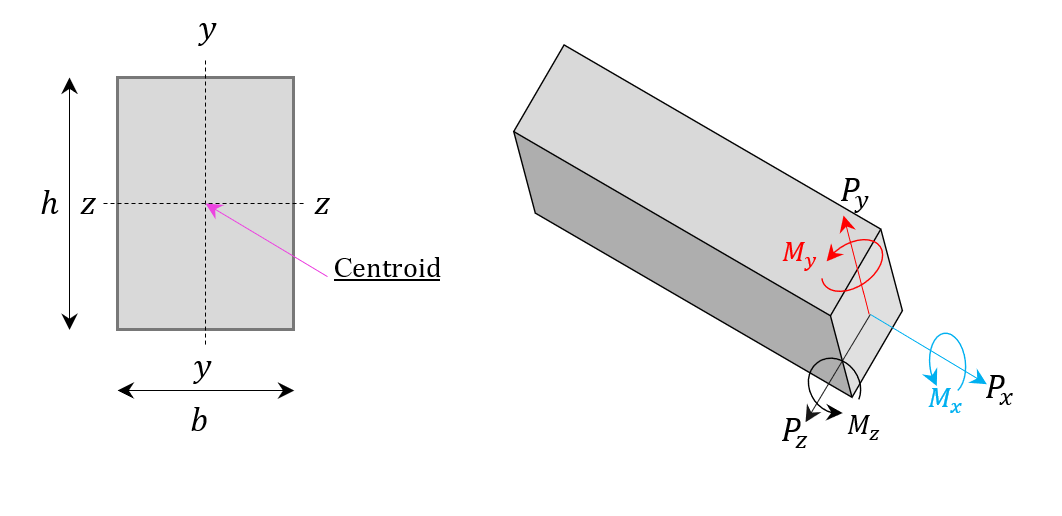

In [30]:
# b=5 and h=10 So considering above location of centroid
# coordinate of corners of rectangle becomes [-2.5,5] and [2.5,5]

Model(P=0, Mz=5000, crdsIz=-2.5, crdsIy=-5, crdsJz=2.5, crdsJy=5, numSubdivY=20, numSubdivZ=20)

Support Reaction (Px,Mz,My)=(-0.0 -5000.0 -0.0)

-------------------------------------------------------------------------------------------------------------------
Ybar= -0.0

By moving force to the center of the section the Mz= 5000.0
By moving force to the center of the section the My= -0.0

max and min of Calculated Stress at a fiber location= 57.14285714285725 -57.14285714285725
max and min of Handy Calculated Stress at a fiber location= 57.0000000000001 -57.0000000000001

max and min of Calculated Strain at a fiber location= 2.721088435374155e-05 -2.721088435374155e-05
max and min of Handy Calculated Strain at a fiber location= 2.7142857142857192e-05 -2.7142857142857192e-05
-------------------------------------------------------------------------------------------------------------------


### Centroid at center and under Axial force(Px) and Mz

In [31]:
# b=5 and h=10 So considering above location of centroid
# coordinate of corners of rectangle becomes [-2.5,5] and [2.5,5]
Model(P=10000, Mz=5000, crdsIz=-2.5, crdsIy=-5, crdsJz=2.5, crdsJy=5, numSubdivY=20, numSubdivZ=20)

Support Reaction (Px,Mz,My)=(-10000.0 -5000.0 0.0)

-------------------------------------------------------------------------------------------------------------------
Ybar= -0.0

By moving force to the center of the section the Mz= 5000.0
By moving force to the center of the section the My= -0.0

max and min of Calculated Stress at a fiber location= 257.14285714285717 142.85714285714278
max and min of Handy Calculated Stress at a fiber location= 257.0000000000001 142.99999999999986

max and min of Calculated Strain at a fiber location= 0.00012244897959183676 6.80272108843537e-05
max and min of Handy Calculated Strain at a fiber location= 0.00012238095238095243 6.809523809523804e-05
-------------------------------------------------------------------------------------------------------------------


## Change Location of the centroid

Considering Centroid at center bottom of the section

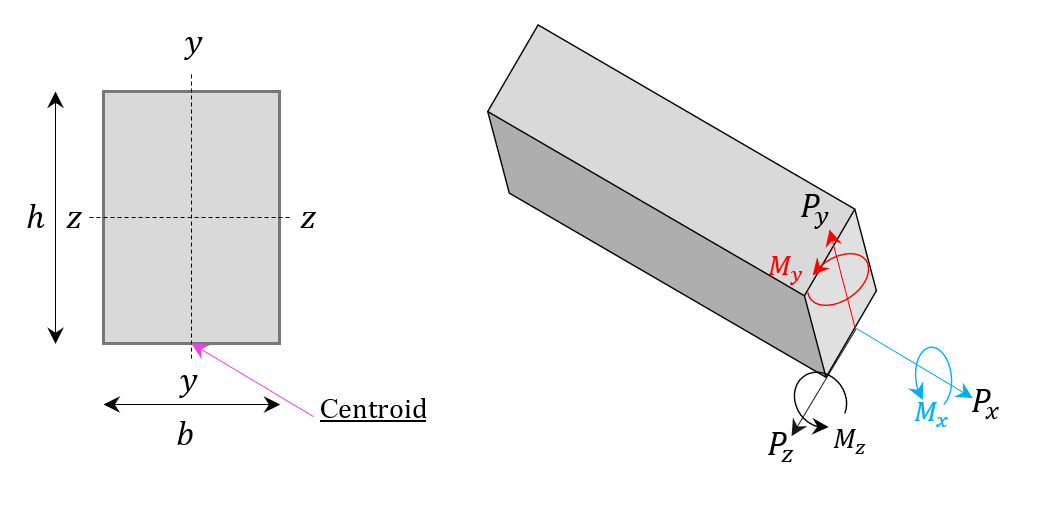

In [25]:
# b=5 and h=10 So considering above location of centroid
# coordinate of corners of rectangle becomes [-2.5,0] and [2.5,10]
Model(P=10000, Mz=5000, crdsIz=-2.5, crdsIy=0, crdsJz=2.5, crdsJy=10, numSubdivY=20, numSubdivZ=20)

Support Reaction (Px,Mz,My)=(-10000.0 -5000.0 0.0)

-------------------------------------------------------------------------------------------------------------------
Ybar= 5.0

By moving force to the center of the section the Mz= 55000.0
By moving force to the center of the section the My= -0.0

max and min of Calculated Stress at a fiber location= 828.5714285714283 -428.57142857142895
max and min of Handy Calculated Stress at a fiber location= 827.0000000000005 -427.0

max and min of Calculated Strain at a fiber location= 0.0003945578231292516 -0.0002040816326530614
max and min of Handy Calculated Strain at a fiber location= 0.00039380952380952403 -0.00020333333333333336
-------------------------------------------------------------------------------------------------------------------


## Change Location of the centroid

Considering Centroid at center corner of the section

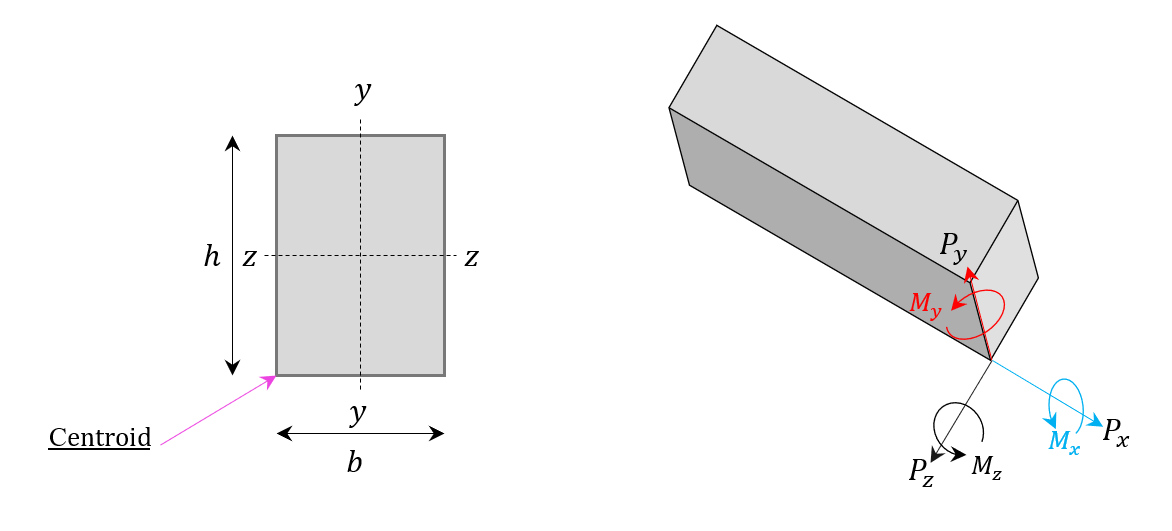

In [26]:
# b=5 and h=10 So considering above location of centroid
# coordinate of corners of rectangle becomes [0,0] and [5,10]
Model(P=10000, Mz=5000, crdsIz=0, crdsIy=0, crdsJz=5, crdsJy=10, numSubdivY=20, numSubdivZ=20)

Support Reaction (Px,Mz,My)=(-10000.0 -5000.0 0.0)

-------------------------------------------------------------------------------------------------------------------
Ybar= 5.0

By moving force to the center of the section the Mz= 55000.0
By moving force to the center of the section the My= 25000.0

max and min of Calculated Stress at a fiber location= 1399.999999999999 -999.9999999999989
max and min of Handy Calculated Stress at a fiber location= 1397.0000000000061 -997.0

max and min of Calculated Strain at a fiber location= 0.0006666666666666662 -0.00047619047619047565
max and min of Handy Calculated Strain at a fiber location= 0.0006652380952380982 -0.0004747619047619048
-------------------------------------------------------------------------------------------------------------------


# Results

* If user uses '-noCentroid' and the end of defining fiber section ***section('Fiber', secTag, '-GJ', GJ,'-noCentroid')*** OpenSees consider the location of the centroin exactly on the location of the origin that user considered else it is considered at the centroid of the section.

* OpenSees consider the location of the element internal loads at the centroid of the section.

**Ref:**
[Plane Sections Do Remain Plane By Prof. Michael H. Scott](https://portwooddigital.com/2022/05/15/plane-sections-do-remain-plane/)

# Below Parts Have Not been Completed YET
*************************************************************************************************************************

# Plastic Investigation

In [6]:
import openseespy.opensees as ops

ops.wipe()
ops.model('basic','-ndm',3)
L=100
ops.node(1,0,0,0)
ops.node(2,L,0,0)
ops.fix(1,1,1,1,1,1,1)

matTag=1
E=2.1e6
epsyP=0.003
ops.uniaxialMaterial('ElasticPP', matTag, E, epsyP)


transfTag=1
ops.geomTransf('Linear', transfTag,*[0,0,1])

secTag=1
GJ=1
ops.section('Fiber', secTag, '-GJ', GJ)

numSubdivY=20
numSubdivZ=20
b=5
h=10
crdsI=[0,0]
crdsJ=[h,b]
I=b*h**3/12
ops.patch('rect', matTag, numSubdivY, numSubdivZ, *crdsI, *crdsJ)


integrationTag=1
N=3
ops.beamIntegration('Radau', integrationTag, secTag, N)


eleTag=1
eleNodes=[1,2]
ops.element('forceBeamColumn', eleTag, *eleNodes, transfTag, integrationTag)

tstag=1
ops.timeSeries('Linear', tstag)
patternTag=1
ops.pattern('Plain', patternTag, tstag)
nodeTag=2
M=750000
ops.load(nodeTag, *[0,0,0,0,0,M])


# create the analysis
ops.wipeAnalysis()    # clear previously-define analysis parameters
ops.constraints('Plain')    # how it handles boundary conditions
ops.numberer('Plain')    # renumber dof's to minimize band-width (optimization), if you want to
ops.system('BandGeneral') # how to store and solve the system of equations in the analysis
ops.algorithm('Linear') # use Linear algorithm for linear analysis
# create integrator
ops.integrator("LoadControl", 0.01)
# create analysis object
ops.analysis("Static")

# perform the analysis
ops.analyze(100)
ops.reactions()
print('OpenSees Support Reaction=',ops.nodeReaction(1))
print('OpenSees maximum Disp=',ops.nodeDisp(2))
print('Handy Calculated Maximum Delta=',M*L**2/2/E/I)
print('Handy Calculated Maximum Theta=',M*L/E/I)
print('-------------------------------------------------------------------------------------------------------------------')
#                    eleTag             secNum
data = ops.eleResponse(eleTag,'section',3,'fiberData')
# print('\nAll Fiber Data=',data, '\n')
Ndata = len(data)
Nfibers = int(Ndata/5)
# print('Nfibers=',Nfibers, '\n')

y = data[0:Ndata:5]
z = data[1:Ndata:5]
# print('y=',y,'z=',z)

A = data[2:Ndata:5] # If you want fiber areas
sig = data[3:Ndata:5]
eps = data[4:Ndata:5]
# print('A=',A)
# print('sig=',sig)
# print('eps=',eps)
Ybar=sum([yi*ai for yi,ai in zip(y,A)])/sum([ai for ai in A])
print('Ybar=',Ybar)
print('max and min of Calculated Stress at a fiber location=', max(sig), min(sig))
print('max and min of Handy Calculated Stress at a fiber location=', max([M*(Y-Ybar)/I for Y in y]), min([M*(Y-Ybar)/I for Y in y]))
print('\nSo OpenSees returns the fiber section coordinate points according the coordinate considered by the user!')
print('')
print('max and min of Calculated Strain at a fiber location=', max(eps), min(eps))
print('max and min of Handy Calculated Strain at a fiber location=', max([M*(Y-5)/E/I for Y in y]), min([M*(Y-5)/E/I for Y in y]))
print('-------------------------------------------------------------------------------------------------------------------')




OpenSees Support Reaction= [-4.312443364459165e-12, -1.1641532182693482e-12, -1.1988935876530871e-14, 0.0, -5.279348556813814e-12, -750000.0000000005]
OpenSees maximum Disp= [5.719955272219064e-17, 8.027210882161356, -8.238120818159267e-16, 0.0, 1.723060937763858e-17, 0.1605442176549659]
Handy Calculated Maximum Delta= 4.285714285714286
Handy Calculated Maximum Theta= 0.08571428571428572
-------------------------------------------------------------------------------------------------------------------
Ybar= 5.0
max and min of Calculated Stress at a fiber location= 6300.0 -6300.0
max and min of Handy Calculated Stress at a fiber location= 8550.000000000051 -8550.0

So OpenSees returns the fiber section coordinate points according the coordinate considered by the user!

max and min of Calculated Strain at a fiber location= 0.007625850340136045 -0.007625850340136088
max and min of Handy Calculated Strain at a fiber location= 0.004071428571428596 -0.004071428571428571
---------------------

# Investigation on torsion

OpenSees Support Reaction= [0.0, 0.0, 0.0, -4999999.999999999, 0.0, 0.0]
OpenSees maximum Disp= [0.0, 0.0, 0.0, 0.07882191550836347, 0.0, 0.0]
-------------------------------------------------------------------------------------------------------------------
data[1:5]= [0.32787721436115536, 0.0519306490917596, 0.039269908169872414, 0.0, 0.0, 0.2957823081646041]
J= 5.0
max and min of handy Calculated Stress at a fiber location= 0.07882191552412784
max and min of Calculated Stress at a fiber location= 0.0 0.0

max and min of Calculated Strain at a fiber location= 0.0 0.0
-------------------------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


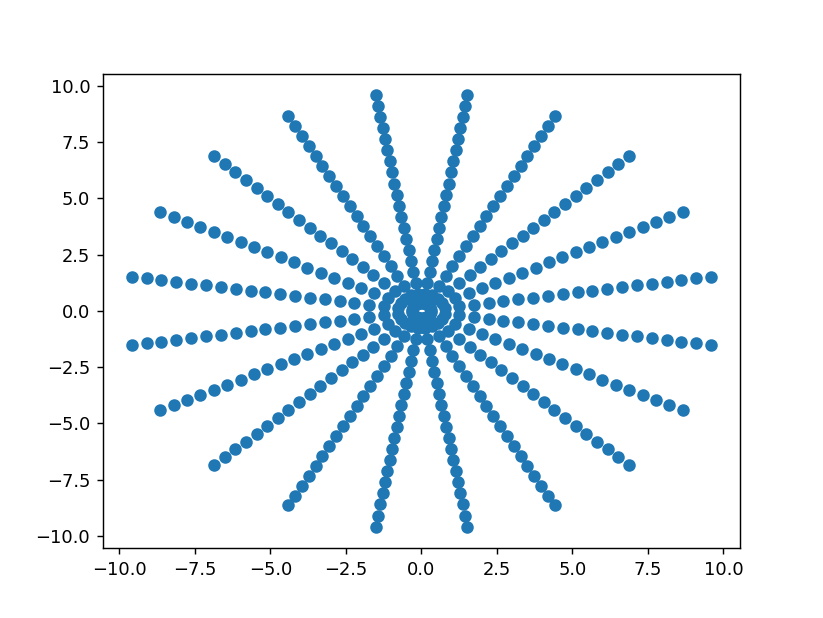

In [7]:
import openseespy.opensees as ops
import matplotlib.pyplot as plt
%matplotlib notebook
ops.wipe()
ops.model('basic','-ndm',3)
L=100
ops.node(1,0,0,0)
ops.node(2,L,0,0)
ops.fix(1,1,1,1,1,1,1)

matTag=1
E=2.1e6
epsyP=1
ops.uniaxialMaterial('ElasticPP', matTag, E, epsyP)


transfTag=1
ops.geomTransf('Linear', transfTag,*[0,0,1])
r=10
J=3.1415*r**4/4
secTag=1
G=E/2/(1+0.3)
GJ=G*J
ops.section('Fiber', secTag, '-GJ', GJ)

numSubdivCirc=20
numSubdivRad=20

center=[0,0]
rad=[0,r]
ang=[0,360]
crdsI=[0,0]
crdsJ=[h,b]
ops.patch('circ', matTag, numSubdivCirc, numSubdivRad, *center, *rad, *ang)


integrationTag=1
N=3
ops.beamIntegration('Radau', integrationTag, secTag, N)


eleTag=1
eleNodes=[1,2]
ops.element('forceBeamColumn', eleTag, *eleNodes, transfTag, integrationTag)

tstag=1
ops.timeSeries('Linear', tstag)
patternTag=1
ops.pattern('Plain', patternTag, tstag)
nodeTag=2
T=5000000
ops.load(nodeTag, *[0,0,0,T,0,0])


# create the analysis
ops.wipeAnalysis()    # clear previously-define analysis parameters
ops.constraints('Plain')    # how it handles boundary conditions
ops.numberer('Plain')    # renumber dof's to minimize band-width (optimization), if you want to
ops.system('BandGeneral') # how to store and solve the system of equations in the analysis
ops.algorithm('Linear') # use Linear algorithm for linear analysis
# create integrator
ops.integrator("LoadControl", 0.1)
# create analysis object
ops.analysis("Static")

# perform the analysis
ops.analyze(10)
ops.reactions()
print('OpenSees Support Reaction=',ops.nodeReaction(1))
print('OpenSees maximum Disp=',ops.nodeDisp(2))
# print('Handy Calculated Maximum Delta=',M*L**2/2/E/I)
# print('Handy Calculated Maximum Theta=',M*L/E/I)
print('-------------------------------------------------------------------------------------------------------------------')
#                    eleTag             secNum
data = ops.eleResponse(eleTag,'section',3,'fiberData')
# print('\nAll Fiber Data=',data, '\n')
Ndata = len(data)
Nfibers = int(Ndata/5)
# print('Nfibers=',Nfibers, '\n')
print('data[1:5]=',data[0:6])
y = data[0:Ndata:5]
z = data[1:Ndata:5]
# print('y=',y,'\nz=',z)

A = data[2:Ndata:5] # If you want fiber areas
sig = data[3:Ndata:5]
eps = data[4:Ndata:5]
# print('A=',A)
# print('sig=',sig)
# print('eps=',eps)

print('J=',Ybar)
print('max and min of handy Calculated Stress at a fiber location=', T/G/J*L)
print('max and min of Calculated Stress at a fiber location=', max(sig), min(sig))
print('')
print('max and min of Calculated Strain at a fiber location=', max(eps), min(eps))
print('-------------------------------------------------------------------------------------------------------------------')

plt.scatter(y,z)

